In [1]:
import pandas as pd 
from pulp import *
import re
import numpy as np

# Data Preparation

In [2]:
with open('data_1.txt', 'r') as fp:
    x1 = fp.readlines()

with open('data_2.txt', 'r') as fp:
    x2 = fp.readlines()

x1 = [re.sub('\n','',i) for i in x1]
x2 = [re.sub('\n','',i) for i in x2]

In [3]:
df = pd.DataFrame([tuple(re.split(',',i)) for i in x1])
df.columns = df.iloc[0]
df.drop(df.index[0], inplace=True)
df.reset_index(drop=True, inplace=True)

df_2 = pd.DataFrame([tuple(re.split(',',i)) for i in x2])
df_2.columns = df_2.iloc[0]
df_2.drop(df_2.index[0], inplace=True)
df_2.reset_index(drop=True, inplace=True)

In [4]:
df[' Inventory Cost(100 units)']=df[' Inventory Cost(100 units)'].astype(int)
df[' Capacity'] = df[' Capacity'].astype(float)
df[' Disruption Probability(1 - µ)'] = df[' Disruption Probability(1 - µ)'].astype(float)
df[' TTR of vendor']=df[' TTR of vendor'].astype(float)

In [5]:
df

,Plant,Inventory Cost(100 units),Vendor,Capacity,Disruption Probability(1 - µ),TTR of vendor
0,ABX,31,1,1.2,0.0667,1.0
1,ABN,30,1,1.2,0.0667,1.0
2,GHY,32,2,0.9,0.1333,1.2
3,KJU,29,3,0.5,0.2000,1.4
4,PFR,30,4,0.5,0.1667,1.6
5,JKI1,30,5,2.4,0.0667,1.8
6,JKI2,33,5,2.4,0.0667,1.8
7,JKI3,31,5,2.4,0.0667,1.8
8,CFG1,500,6,0.2,0.0667,2.0
9,CFG2,550,7,0.4,0.1667,2.2


In [6]:
df_2

,ItemID,Vendor,Geographic Location,CFG1,CFG2,CFG3,CFG4
0,ABX,1,US,1,1,1,0
1,ABN,1,US,1,1,1,0
2,GHY,2,Mexico,1,1,2,1
3,KJU,3,Mexico,1,0,1,0
4,PFR,4,US,1,0,1,0
5,JKI1,5,Mexico,0,3,0,0
6,JKI2,5,Mexico,3,0,0,0
7,JKI3,5,Mexico,2,0,3,2
8,CFG1,6,US,1,0,0,0
9,CFG2,7,US,0,1,0,0


In [7]:
d = {}
for i in range(8):
    item = df_2['ItemID'].iloc[i]
    cfg1 = df_2[' CFG1'].iloc[i] 
    cfg2 = df_2[' CFG2'].iloc[i]
    cfg3 = df_2[' CFG3'].iloc[i]
    cfg4 = df_2[' CFG4'].iloc[i]
    d[(item,'CFG1')] = int(cfg1)
    d[(item,'CFG2')] = int(cfg2)
    d[(item,'CFG3')] = int(cfg3)
    d[(item,'CFG4')] = int(cfg4)
B = d

# Defining Parameters

In [8]:
# Create a list of the Plant Nodes
M = df['Plant'].tolist()
M1 = df['Plant'].tolist()[0:8]
M2 = df['Plant'].tolist()[8:]
N = [f'C{i}' for i in range(5)]

# Create a dictionary of capacity for all Plant nodes
capacity_x = dict(zip(M1,df[' Capacity']))
capacity_y = dict(zip(M2,df[' Capacity']))

# Create a dictionary of disruption probability for all Plant nodes
dis_prob = dict(zip(M1,df[' Disruption Probability(1 - µ)']))

# Create a dictionary of inventory costs
inv_cost_x = dict(zip(M1,df[' Inventory Cost(100 units)'].iloc[0:8]))
inv_cost_y = dict(zip(M2,df[' Inventory Cost(100 units)'].iloc[8:]))


# # Demand from all customers for different products
# demand = {
#     'C0':{'CFG1':20, 'CFG2':10, 'CFG3':0, 'CFG4':0},
#     'C1':{'CFG1':20, 'CFG2':0, 'CFG3':20, 'CFG4':40},
#     'C2':{'CFG1':10, 'CFG2':50, 'CFG3':0, 'CFG4':0},
#     'C3':{'CFG1':10, 'CFG2':10, 'CFG3':10, 'CFG4':0},
#     'C4':{'CFG1':60, 'CFG2':0, 'CFG3':20, 'CFG4':20},
#     'C5':{'CFG1':40, 'CFG2':0, 'CFG3':0, 'CFG4':30},
#     'C6':{'CFG1':40, 'CFG2':10, 'CFG3':20, 'CFG4':10},
#     'C7':{'CFG1':20, 'CFG2':0, 'CFG3':10, 'CFG4':0},
#     'C8':{'CFG1':10, 'CFG2':20, 'CFG3':10, 'CFG4':0},
#     'C9':{'CFG1':30, 'CFG2':0, 'CFG3':10, 'CFG4':20},
#     }

Tr =  dict(zip(M1,df[' TTR of vendor']))

# Lost Sales Penalty
f = {
    'C0':5, 'C1':7, 'C2':6, 'C3':6, 
    'C4':8}

In [9]:
demand = {
    'C0':{'W1':{'CFG1':0, 'CFG2':0, 'CFG3':10, 'CFG4':0},
          'W2':{'CFG1':0, 'CFG2':10, 'CFG3':300, 'CFG4':0},
          'W3':{'CFG1':0, 'CFG2':100, 'CFG3':0, 'CFG4':0},
          'W4':{'CFG1':200, 'CFG2':10, 'CFG3':0, 'CFG4':0}
         },
    'C1':{'W1':{'CFG1':0, 'CFG2':10, 'CFG3':10, 'CFG4':0},
          'W2':{'CFG1':0, 'CFG2':50, 'CFG3':10, 'CFG4':0},
          'W3':{'CFG1':0, 'CFG2':10, 'CFG3':0, 'CFG4':0},
          'W4':{'CFG1':0, 'CFG2':10, 'CFG3':0, 'CFG4':0}
         },
    'C2':{'W1':{'CFG1':0, 'CFG2':10, 'CFG3':0, 'CFG4':0},
          'W2':{'CFG1':300, 'CFG2':0, 'CFG3':0, 'CFG4':0},
          'W3':{'CFG1':0, 'CFG2':0, 'CFG3':500, 'CFG4':0},
          'W4':{'CFG1':0, 'CFG2':0, 'CFG3':200, 'CFG4':0}
         },
    'C3':{'W1':{'CFG1':0, 'CFG2':10, 'CFG3':0, 'CFG4':0},
          'W2':{'CFG1':100, 'CFG2':10, 'CFG3':550, 'CFG4':0},
          'W3':{'CFG1':0, 'CFG2':10, 'CFG3':0, 'CFG4':0},
          'W4':{'CFG1':0, 'CFG2':10, 'CFG3':0, 'CFG4':0}
         },
    'C4':{'W1':{'CFG1':20, 'CFG2':10, 'CFG3':0, 'CFG4':0},
          'W2':{'CFG1':0, 'CFG2':10, 'CFG3':0, 'CFG4':0},
          'W3':{'CFG1':600, 'CFG2':10, 'CFG3':0, 'CFG4':0},
          'W4':{'CFG1':0, 'CFG2':0, 'CFG3':0, 'CFG4':0}
         }
    }

W = ['W1', 'W2', 'W3', 'W4']

In [10]:
dis_prob

{'ABX': 0.0667,
 'ABN': 0.0667,
 'GHY': 0.1333,
 'KJU': 0.2,
 'PFR': 0.1667,
 'JKI1': 0.0667,
 'JKI2': 0.0667,
 'JKI3': 0.0667}

# Defining Random Variables

In [11]:
np.random.seed(9)
v = np.random.random(size=(1,32))
v

array([[0.01037415, 0.50187459, 0.49577329, 0.13382953, 0.14211109,
        0.21855868, 0.41850818, 0.24810117, 0.08405965, 0.34549864,
        0.16677635, 0.87855909, 0.95096403, 0.03874838, 0.69910739,
        0.57275982, 0.89800712, 0.66689897, 0.54783778, 0.70242742,
        0.38647717, 0.69443868, 0.82487046, 0.46566848, 0.94052441,
        0.80373977, 0.98335925, 0.16963626, 0.52108471, 0.94551742,
        0.64954046, 0.86083192]])

In [12]:
c = 0
d = {}
for i in range(len(M1)):
    for t in range(len(W)):
        d[(M1[i],W[t])] = v[0][c]
        c+=1

In [13]:
d

{('ABX', 'W1'): 0.010374153885699955,
 ('ABX', 'W2'): 0.5018745921487388,
 ('ABX', 'W3'): 0.4957732931341461,
 ('ABX', 'W4'): 0.13382952895927658,
 ('ABN', 'W1'): 0.14211108545453854,
 ('ABN', 'W2'): 0.21855867562607822,
 ('ABN', 'W3'): 0.41850818051045247,
 ('ABN', 'W4'): 0.24810116841355911,
 ('GHY', 'W1'): 0.08405965116535008,
 ('GHY', 'W2'): 0.3454986400504001,
 ('GHY', 'W3'): 0.16677634653232143,
 ('GHY', 'W4'): 0.878559085532659,
 ('KJU', 'W1'): 0.9509640316267165,
 ('KJU', 'W2'): 0.038748375832319826,
 ('KJU', 'W3'): 0.699107391398761,
 ('KJU', 'W4'): 0.5727598155694092,
 ('PFR', 'W1'): 0.8980071182251496,
 ('PFR', 'W2'): 0.6668989729196366,
 ('PFR', 'W3'): 0.5478377830464816,
 ('PFR', 'W4'): 0.7024274240680553,
 ('JKI1', 'W1'): 0.3864771696146654,
 ('JKI1', 'W2'): 0.6944386777644582,
 ('JKI1', 'W3'): 0.8248704645005481,
 ('JKI1', 'W4'): 0.46566847536726585,
 ('JKI2', 'W1'): 0.9405244095266561,
 ('JKI2', 'W2'): 0.8037397700123178,
 ('JKI2', 'W3'): 0.9833592482243325,
 ('JKI2', '

# Problem Definition

In [14]:
obj = LpProblem("Disruption_Risk_Mitigation",LpMinimize)

# Defining Decision Variables

In [15]:
# Since x is Continuous
x  = {(i,t,j):
           LpVariable(cat=LpContinuous, 
               lowBound=0,  
               name="x_{0}_{1}_{2}".format(i,t,j)) 
for i in M1 for t in W for j in M2}


In [16]:
# Since x is Continuous
y = {(j,t,k):
           LpVariable(cat=LpContinuous, 
               lowBound=0,
               name="y_{0}_{1}_{2}".format(j,t,k)) 
for j in M2 for t in W for k in N}

In [17]:
# Since x is Continuous
l = {(j,t,k):
           LpVariable(cat=LpContinuous, 
               lowBound=0, 
               name="l_{0}_{1}_{2}".format(j,t,k)) 
for j in M2 for t in W for k in N}

In [18]:
# Inventory Decision Variable for Stage 1
r_x = {(i,t):
           LpVariable(cat=LpContinuous, 
               lowBound=0, 
               name="inventory_prod_x_{0}_{1}".format(i,t)) 
for i in M1 for t in W}

# Inventory Decision Variable for Stage 2
r_y = {(j,t):
           LpVariable(cat=LpContinuous, 
               lowBound=0, 
               name="inventory_prod_y_{0}_{1}".format(j,t)) 
for j in M2 for t in W}

# Amount of product sold in each week
q = {(j,t,k):
           LpVariable(cat=LpContinuous, 
               lowBound=0, 
               name="amount_sold_{0}_{1}_{2}".format(j,t,k)) 
for j in M2 for t in W for k in N}

In [19]:
# Disruption Variable for Stage 1
d_x = {(i,t):
           LpVariable(cat=LpInteger, 
               lowBound=0, upBound=1,
               name="disruption_{0}_{1}".format(i,t)) 
for i in M1 for t in W}

In [20]:
TRV = LpVariable(cat=LpContinuous, lowBound=0, name="TRV")

# Defining Objective

In [21]:
obj += lpSum([f[k]*l[(j,t,k)]*100 for j in M2 for t in W for k in N] + 
             [inv_cost_y[j]*r_y[(j,t)]*0.00001 for j in M2 for t in W] + 
             [inv_cost_x[i]*x[(i,t,j)] for i in M1 for t in W for j in M2]
            )

# Defining Constraints

In [22]:
# Disruption Constraint: If stablity probability > disruption probability then d_x = 0 else 1
for i in M1:
    for t in W:
        if d[(i,t)] > dis_prob[i]:
            obj += d_x[(i,t)] == 0 
        else:
            obj += d_x[(i,t)] == 1

In [23]:
# Constraint relating to TTR and TRV
for i in M1:
    for t in W:
        obj += TRV >= max((Tr[i]*(1-d_x[(i,t)])))

In [24]:
# Capacity Constraint of x using disruption variable & TTR
for i in M1:
    for t in W:
        obj += lpSum(x[(i,t,j)] for j in M2) <= capacity_x[i]*100*(TRV - (Tr[i]*(1-d_x[(i,t)])))
        
# Capacity Constraint of y
for j in M2:
    for t in W:
        obj += lpSum(y[(j,t,k)] for k in N) <= capacity_y[j]*100

In [25]:
# Constraint #1: Stage 2 Production depends on Stage 1 supply
for j in M2:
    for t in W:
        obj += lpSum(x[(i,t,j)] for i in M1) >= lpSum(y[(j,t,k)] for k in N)

In [26]:
# Constraint #2 Inventory today <= invent yest - sold today + prod today
for t in range(1, len(W)):
    for j in M2:
        obj += r_y[(j,W[t])] <= r_y[(j,W[t-1])] + lpSum(y[(j,W[t],k)] for k in N) - lpSum(q[(j,W[t],k)] for k in N)

# Constraint for Day 1: Since there is no inventory on day 0
for j in M2:
    obj += r_y[(j,'W1')] <= lpSum(y[(j,'W1',k)] for k in N) - lpSum(q[(j,'W1',k)] for k in N)

In [27]:
# Constraint #3 Demand and Sold Constraint
for j in M2:
    for t in W:
        for k in N:
            obj += q[(j,t,k)] <= demand[k][t][j]

In [28]:
# Constraint #4 Lost Sales
for j in M2:
    for t in W:
        for k in N:
            obj += l[(j,t,k)] == demand[k][t][j] - q[(j,t,k)]

In [29]:
obj.solve()

1

In [30]:
for v in obj.variables():
    if (v.varValue>0):
        print(v.name, "=", v.varValue)

TRV = 8.0
amount_sold_CFG1_W1_C4 = 20.0
amount_sold_CFG1_W3_C4 = 340.0
amount_sold_CFG1_W4_C0 = 120.0
amount_sold_CFG2_W1_C1 = 10.0
amount_sold_CFG2_W1_C2 = 10.0
amount_sold_CFG2_W1_C3 = 10.0
amount_sold_CFG2_W1_C4 = 10.0
amount_sold_CFG2_W2_C0 = 10.0
amount_sold_CFG2_W2_C1 = 50.0
amount_sold_CFG2_W2_C3 = 10.0
amount_sold_CFG2_W2_C4 = 10.0
amount_sold_CFG2_W3_C0 = 100.0
amount_sold_CFG2_W3_C1 = 10.0
amount_sold_CFG2_W3_C3 = 10.0
amount_sold_CFG2_W3_C4 = 10.0
amount_sold_CFG2_W4_C0 = 10.0
amount_sold_CFG2_W4_C1 = 10.0
amount_sold_CFG2_W4_C3 = 10.0
amount_sold_CFG3_W1_C1 = 10.0
amount_sold_CFG3_W2_C1 = 10.0
amount_sold_CFG3_W2_C3 = 160.0
amount_sold_CFG3_W3_C2 = 90.0
amount_sold_CFG3_W4_C2 = 90.0
disruption_ABX_W1 = 1.0
disruption_GHY_W1 = 1.0
disruption_KJU_W2 = 1.0
inventory_prod_y_CFG1_W1 = 100.0
inventory_prod_y_CFG1_W2 = 220.0
inventory_prod_y_CFG2_W2 = 10.0
inventory_prod_y_CFG3_W1 = 80.0
l_CFG1_W2_C2 = 300.0
l_CFG1_W2_C3 = 100.0
l_CFG1_W3_C4 = 260.0
l_CFG1_W4_C0 = 80.0
l_CFG3_W1_C

In [36]:
value(obj.objective)

1221482.135

In [32]:
k = []
for v in obj.variables():
    if (v.varValue>0):
        k.append((v.name, v.varValue))

In [41]:
df = pd.DataFrame(k, columns=['name', 'value'])

# Output

In [43]:
import re

In [103]:
df[20:]

,name,value,amount_sold,weeks
20,amount_sold_CFG3_W2_C1,10.0,[W2],W2
21,amount_sold_CFG3_W2_C3,160.0,[W2],W2
22,amount_sold_CFG3_W3_C2,90.0,[W3],W3
23,amount_sold_CFG3_W4_C2,90.0,[W4],W4
24,disruption_ABX_W1,1.0,[],W1
25,disruption_GHY_W1,1.0,[],W1
26,disruption_KJU_W2,1.0,[],W2
27,inventory_prod_y_CFG1_W1,100.0,[],W1
28,inventory_prod_y_CFG1_W2,220.0,[],W2
29,inventory_prod_y_CFG2_W2,10.0,[],W2


In [113]:
def weeks_func(df):
    try:
        return re.findall('.*_(W[0-9])',df)[0]
    except:
        return None

def amount_func(df):
    try:
        return re.findall('amount_sold',df)[0]
    except:
        return None

def x_func(df):
    try:
        return re.findall('x',df)[0]
    except:
        return None

def y_func(df):
    try:
        return re.findall('y',df)[0]
    except:
        return None

    
def inv_func(df):
    try:
        return re.findall('inventory_prod',df)[0]
    except:
        return None

def lost_func(df):
    try:
        return re.findall('l',df)[0]
    except:
        return None

In [114]:
df['weeks'] = df['name'].apply(weeks_func)
df['amount_sold'] = df['name'].apply(amount_func)
df['x'] = df['name'].apply(x_func)
df['y'] = df['name'].apply(y_func)
df['invent_y'] = df['name'].apply(inv_func)
df['lost_sales'] = df['name'].apply(lost_func)

In [128]:
x = df.dropna(subset=['x'])
y = df.dropna(subset=['y'])
l = df.dropna(subset=['lost_sales'])
a = df.dropna(subset=['amount_sold'])
i = df.dropna(subset=['invent_y'])

In [119]:
import seaborn as sns

In [120]:
x.head()

,name,value,amount_sold,weeks,x,y,invent_y,lost_sales
40,x_KJU_W1_CFG1,120.0,None,W1,x,None,None,None
41,x_KJU_W1_CFG2,40.0,None,W1,x,None,None,None
42,x_KJU_W1_CFG3,90.0,None,W1,x,None,None,None
43,x_KJU_W2_CFG1,120.0,None,W2,x,None,None,None
44,x_KJU_W2_CFG2,90.0,None,W2,x,None,None,None


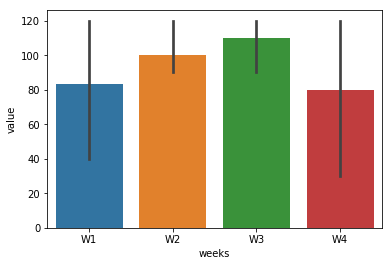

In [121]:
sns.barplot(x="weeks", y="value", data=x)

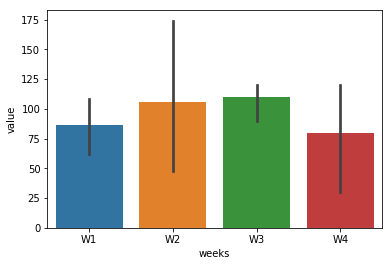

In [123]:
sns.barplot(x="weeks", y="value", data=y)

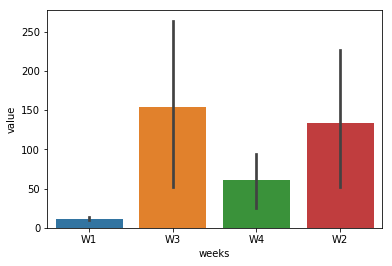

In [125]:
sns.barplot(x="weeks", y="value", data=l)

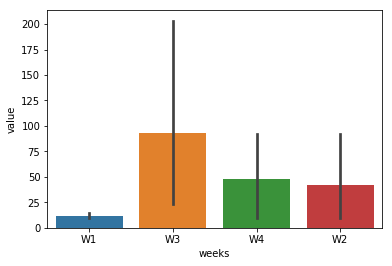

In [127]:
sns.barplot(x="weeks", y="value", data=a)

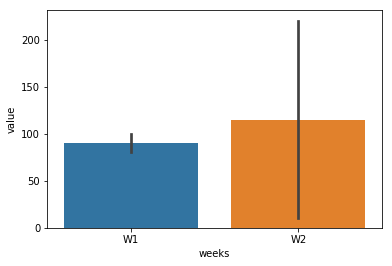

In [129]:
sns.barplot(x="weeks", y="value", data=i)